In [ ]:
import kagglehub
import os
import pickle
import numpy as np
import pandas as pd
import h5py
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import time

dir_path = '/content/drive/MyDrive/COSC 760 project/1. multilayer LSTM'

In [ ]:
class MultiStepLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, horizon, output_size):
        """
        input_size:    number of sensors = 207
        hidden_size:   LSTM hidden dimension (e.g., 64)
        num_layers:    stacked LSTM layers (e.g., 3)
        horizon:       number of future steps to predict (e.g., 3 or 12)
        output_size:   number of sensors = 207
        """
        super().__init__()
        self.horizon = horizon

        # Encode past sequence
        self.encoder = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True
        )

        # Linear head to map hidden state to output_size
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        """
        x: (batch, lookback, input_size)
        Returns: (batch, horizon, output_size)
        """
        batch_size = x.size(0)

        _, (h_n, c_n) = self.encoder(x)

        h = h_n
        c = c_n

        outputs = []

        for _ in range(self.horizon):
            decoder_input = torch.zeros(batch_size, 1, x.size(2), device=x.device)
            out, (h, c) = self.encoder(decoder_input, (h, c))

            step_pred = self.fc(out[:, -1, :])  # (batch, output_size)
            outputs.append(step_pred.unsqueeze(1))

        return torch.cat(outputs, dim=1)  # (batch, horizon, output_size)

In [ ]:
metrlaKaggle = "annnnguyen/metr-la-dataset"
metrlaPklFile = 'adj_METR-LA.pkl'
metrlaH5File = 'METR-LA.h5'

agg_rule = '5min'

train_frac = 0.7
val_frac = 0.1
test_frac = 0.2

In [ ]:
def splitAndScale(df):
  print(f'\nImplementing {train_frac}:{val_frac}:{test_frac} train:validation:test split')
  n = len(df)
  n_train = int(n * train_frac)
  n_val   = int(n * val_frac)
  n_test  = n - n_train - n_val

  train_df = df.iloc[:n_train]
  val_df   = df.iloc[n_train:n_train + n_val]
  test_df  = df.iloc[n_train + n_val:]

  print('Scaling with StandardScaler()')

  scaler = StandardScaler()
  scaler.fit(train_df.values)

  train_scaled = scaler.transform(train_df.values)
  val_scaled   = scaler.transform(val_df.values)
  test_scaled  = scaler.transform(test_df.values)

  print(
  f'test shape {train_scaled.shape}\nval shape {val_scaled.shape}\ntest shape {test_scaled.shape}'
  )

  return train_scaled, val_scaled, test_scaled, scaler

In [ ]:
def impute(df):
  df = df.ffill().bfill().fillna(0)
  return df

In [ ]:
def loadAndPreprocess(name, kagglePath, pkl, h5, key):
  path = kagglehub.dataset_download(kagglePath)
  print(f'Saved {name} data to {path}')
  with open(path + '/' + pkl, 'rb') as f:
      graph_data = pickle.load(f, encoding='latin1')

  if isinstance(graph_data, list) and len(graph_data) >= 3:
      sensor_ids = graph_data[0]
      node_ids   = graph_data[1]
      adj_matrix = graph_data[2]
  else:
      raise ValueError("Unexpected structure in the pickle file.")

  print(f"Loaded {name} graph with {len(sensor_ids)} sensors")

  df = pd.read_hdf(path + '/' + h5, key=key)
  df = df.astype('float32')
  print(f"{name} DataFrame shape:", df.shape)

  df = df.resample(agg_rule).mean()
  if np.any(np.isnan(df)):
    print('Imputing missing values')
    df = impute(df)

  print(f'Aggregated {name} dataframe into 5 minute intervals with shape: {df.shape}')

  train_df, val_df, test_df, scaler = splitAndScale(df)
  return train_df, val_df, test_df, scaler, len(sensor_ids)

In [ ]:
train_df, val_df, test_df, scaler, numSensors = loadAndPreprocess('metr-la',metrlaKaggle, metrlaPklFile, metrlaH5File, 'df')

Using Colab cache for faster access to the 'metr-la-dataset' dataset.
Saved metr-la data to /kaggle/input/metr-la-dataset
Loaded metr-la graph with 207 sensors
metr-la DataFrame shape: (34272, 207)
Aggregated metr-la dataframe into 5 minute intervals with shape: (34272, 207)

Implementing 0.7:0.1:0.2 train:validation:test split
Scaling with StandardScaler()
test shape (23990, 207)
val shape (3427, 207)
test shape (6855, 207)


In [ ]:
def make_windows(data_array, lookback=12, horizon=3, step=1):
    # data_array: (T, N) where T = timesteps, N = num_sensors/features
    X, Y = [], []
    T = data_array.shape[0]
    i = 0
    while i + lookback + horizon <= T:
        X.append(data_array[i : i + lookback])            # (lookback, N)
        Y.append(data_array[i + lookback : i + lookback + horizon])  # (horizon, N)
        i += step
    X = np.stack(X)  # (num_samples, lookback, N)
    Y = np.stack(Y)  # (num_samples, horizon, N)
    return X, Y

X_train, Y_train = make_windows(train_df)
X_val,   Y_val   = make_windows(val_df)
X_test,  Y_test  = make_windows(test_df)

In [ ]:
print(X_train.shape, Y_train.shape)

(23976, 12, 207) (23976, 3, 207)


In [ ]:
class TrafficDataset(torch.utils.data.Dataset):
    def __init__(self, X, Y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.Y = torch.tensor(Y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

In [ ]:
train_loader = DataLoader(TrafficDataset(X_train, Y_train), batch_size=64, shuffle=True)
val_loader   = DataLoader(TrafficDataset(X_val,   Y_val), batch_size=64)
test_loader  = DataLoader(TrafficDataset(X_test,  Y_test), batch_size=64)

In [ ]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        """
        Args:
            patience (int): epochs to wait after last improvement.
            min_delta (float): minimum improvement to count as better.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float('inf')
        self.counter = 0
        self.stop = False

    def step(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1

        if self.counter >= self.patience:
            self.stop = True

In [ ]:
model = MultiStepLSTM(input_size=numSensors, hidden_size=64, num_layers=3, horizon=3, output_size=numSensors)

In [ ]:
def train(criterion, optimizer, scheduler, early_stopper, model, train_loader, val_loader):
  best_state = None
  best_val_loss = float('inf')

  train_loss_history = []
  val_loss_history = []

  for epoch in range(100):
      model.train()
      train_losses = []

      for Xbatch, Ybatch in train_loader:
          optimizer.zero_grad()
          pred = model(Xbatch)
          loss = criterion(pred, Ybatch)
          loss.backward()
          optimizer.step()
          train_losses.append(loss.item())

      # --------- VALIDATION --------- #
      model.eval()
      val_losses = []
      with torch.no_grad():
          for Xbatch, Ybatch in val_loader:
              pred = model(Xbatch)
              val_loss = criterion(pred, Ybatch)
              val_losses.append(val_loss.item())

      avg_train_loss = sum(train_losses) / len(train_losses)
      train_loss_history.append(avg_train_loss)

      avg_val_loss = sum(val_losses) / len(val_losses)
      val_loss_history.append(avg_val_loss)

      print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

      # --------- CHECK IMPROVEMENT --------- #
      if avg_val_loss < best_val_loss:
          best_val_loss = avg_val_loss
          best_state = model.state_dict()
          print("> Best model updated.")

      scheduler.step(avg_val_loss)

      # --------- EARLY STOPPING --------- #
      early_stopper.step(avg_val_loss)
      if early_stopper.stop:
          print(f"Early stopping triggered at epoch {epoch+1}")
          break

  # --------- LOAD BEST MODEL --------- #
  if best_state is not None:
      model.load_state_dict(best_state)
      print("Restored best model weights.")

  return train_loss_history, val_loss_history

In [ ]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=5
)

early_stopper = EarlyStopping(patience=10, min_delta=1e-4)

train_loss_history, val_loss_history = train(criterion, optimizer, scheduler, early_stopper, model, train_loader, val_loader)

Epoch 1 | Train Loss: 0.4158 | Val Loss: 0.3576
> Best model updated.
Epoch 2 | Train Loss: 0.2894 | Val Loss: 0.3435
> Best model updated.
Epoch 3 | Train Loss: 0.2541 | Val Loss: 0.3325
> Best model updated.
Epoch 4 | Train Loss: 0.2326 | Val Loss: 0.3388
Epoch 5 | Train Loss: 0.2158 | Val Loss: 0.3160
> Best model updated.
Epoch 6 | Train Loss: 0.2056 | Val Loss: 0.2798
> Best model updated.
Epoch 7 | Train Loss: 0.1966 | Val Loss: 0.2974
Epoch 8 | Train Loss: 0.1905 | Val Loss: 0.3114
Epoch 9 | Train Loss: 0.1820 | Val Loss: 0.3184
Epoch 10 | Train Loss: 0.1777 | Val Loss: 0.2818
Epoch 11 | Train Loss: 0.1741 | Val Loss: 0.2986
Epoch 12 | Train Loss: 0.1676 | Val Loss: 0.3029
Epoch 13 | Train Loss: 0.1572 | Val Loss: 0.3110
Epoch 14 | Train Loss: 0.1546 | Val Loss: 0.3146
Epoch 15 | Train Loss: 0.1510 | Val Loss: 0.3190
Epoch 16 | Train Loss: 0.1494 | Val Loss: 0.3171
Early stopping triggered at epoch 16
Restored best model weights.


In [ ]:
def printMetrics(preds, y):
  mse = np.mean((preds - y) ** 2)
  mae = np.mean(np.abs(preds - y))
  rmse = np.sqrt(mse)
  mask = y != 0
  wape = np.sum(np.abs(preds - y)) / np.sum(np.abs(y)) * 100

  print(f"Test MSE: {mse:.4f} | MAE: {mae:.4f} | RMSE: {rmse:.4f} | WAPE: {wape:.4f}")

def plotTrainingHistory(name, train_hist, val_hist, path):
  plt.figure(figsize=(8,5))
  plt.plot(train_hist, label='Train Loss')
  plt.plot(val_hist, label='Validation Loss')
  plt.xlabel('Epoch')
  plt.ylabel('MSE Loss')
  plt.title(f'{name}: Multi-layer LSTM Training & Validation Loss')
  plt.legend()
  plt.grid(True)
  plt.savefig(f'{path}/{name}_train_val_history.png',dpi=300,bbox_inches='tight')
  plt.show()

def plotSample(name, sensor_idx, horizon_idx, preds, y, path):
  plt.figure(figsize=(12,4))
  plt.plot(preds[:, horizon_idx, sensor_idx], label='Prediction')
  plt.plot(y[:, horizon_idx, sensor_idx], label='Ground Truth')
  plt.xlabel('Sample')
  plt.ylabel('Traffic Speed')
  plt.title(f'{name}: Sensor {sensor_idx} - Horizon {horizon_idx+1}')
  plt.legend()
  plt.savefig(f'{path}/{name}_pred_vs_groundtruth.png',dpi=300,bbox_inches='tight')
  plt.show()

def evaluate(name, model, scaler, test_loader, path):
  model.eval()
  all_preds = []

  with torch.no_grad():
      for Xbatch, _ in test_loader:
          pred = model(Xbatch)  # shape: (batch, horizon, numSensors)
          all_preds.append(pred.cpu())

  # Concatenate all batches
  all_preds = torch.cat(all_preds, dim=0)

  # Flatten before inverse transform
  num_samples, horizon, num_sensors = all_preds.shape
  all_preds_flat = all_preds.reshape(-1, num_sensors)
  Y_test_flat    = Y_test.reshape(-1, num_sensors)

  # Inverse transform
  all_preds_inv = scaler.inverse_transform(all_preds_flat)
  Y_test_inv    = scaler.inverse_transform(Y_test_flat)

  # Reshape back to (samples, horizon, sensors)
  all_preds_inv = all_preds_inv.reshape(num_samples, horizon, num_sensors)
  Y_test_inv    = Y_test_inv.reshape(num_samples, horizon, num_sensors)

  printMetrics(all_preds_inv, Y_test_inv)
  plotSample(name,0,0,all_preds_inv,Y_test_inv,path)

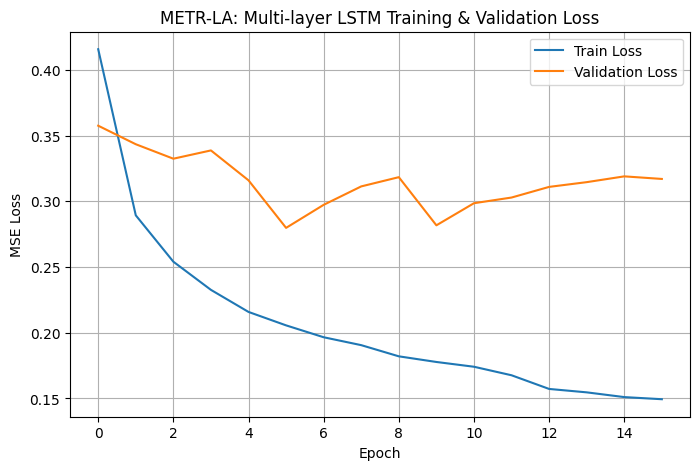

In [ ]:
plotTrainingHistory('METR-LA', train_loss_history, val_loss_history, dir_path)

Test MSE: 144.4571 | MAE: 6.1239 | RMSE: 12.0190 | WAPE: 12.0661


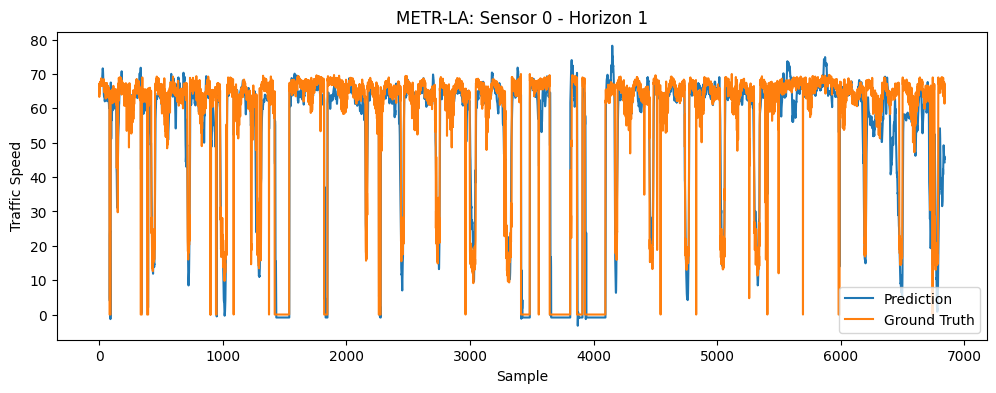

In [ ]:
evaluate('METR-LA', model, scaler, test_loader, dir_path)

In [ ]:
pemsbayKaggle = "scchuy/pemsbay"
pemsbayPklFile = 'adj_mx_bay.pkl'
pemsbayH5File = 'pems-bay.h5'

In [ ]:
train_df, val_df, test_df, scaler, numSensors = loadAndPreprocess('pemsbay', pemsbayKaggle, pemsbayPklFile, pemsbayH5File, 'speed')

Using Colab cache for faster access to the 'pemsbay' dataset.
Saved pemsbay data to /kaggle/input/pemsbay
Loaded pemsbay graph with 325 sensors
pemsbay DataFrame shape: (52116, 325)
Imputing missing values
Aggregated pemsbay dataframe into 5 minute intervals with shape: (52128, 325)

Implementing 0.7:0.1:0.2 train:validation:test split
Scaling with StandardScaler()
test shape (36489, 325)
val shape (5212, 325)
test shape (10427, 325)


In [ ]:
X_train, Y_train = make_windows(train_df)
X_val,   Y_val   = make_windows(val_df)
X_test,  Y_test  = make_windows(test_df)

In [ ]:
train_loader = DataLoader(TrafficDataset(X_train, Y_train), batch_size=64, shuffle=True)
val_loader   = DataLoader(TrafficDataset(X_val,   Y_val), batch_size=64)
test_loader  = DataLoader(TrafficDataset(X_test,  Y_test), batch_size=64)

In [ ]:
model = MultiStepLSTM(input_size=numSensors, hidden_size=64, num_layers=3, horizon=3, output_size=numSensors)

In [ ]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=5
)

early_stopper = EarlyStopping(patience=10, min_delta=1e-4)

train_loss_history, val_loss_history = train(criterion, optimizer, scheduler, early_stopper, model, train_loader, val_loader)

Epoch 1 | Train Loss: 0.3826 | Val Loss: 0.4588
> Best model updated.
Epoch 2 | Train Loss: 0.2843 | Val Loss: 0.4162
> Best model updated.
Epoch 3 | Train Loss: 0.2547 | Val Loss: 0.3925
> Best model updated.
Epoch 4 | Train Loss: 0.2355 | Val Loss: 0.3770
> Best model updated.
Epoch 5 | Train Loss: 0.2208 | Val Loss: 0.3634
> Best model updated.
Epoch 6 | Train Loss: 0.2097 | Val Loss: 0.3618
> Best model updated.
Epoch 7 | Train Loss: 0.2014 | Val Loss: 0.3560
> Best model updated.
Epoch 8 | Train Loss: 0.1949 | Val Loss: 0.3544
> Best model updated.
Epoch 9 | Train Loss: 0.1893 | Val Loss: 0.3504
> Best model updated.
Epoch 10 | Train Loss: 0.1843 | Val Loss: 0.3471
> Best model updated.
Epoch 11 | Train Loss: 0.1798 | Val Loss: 0.3497
Epoch 12 | Train Loss: 0.1763 | Val Loss: 0.3454
> Best model updated.
Epoch 13 | Train Loss: 0.1735 | Val Loss: 0.3441
> Best model updated.
Epoch 14 | Train Loss: 0.1703 | Val Loss: 0.3420
> Best model updated.
Epoch 15 | Train Loss: 0.1680 | Val L

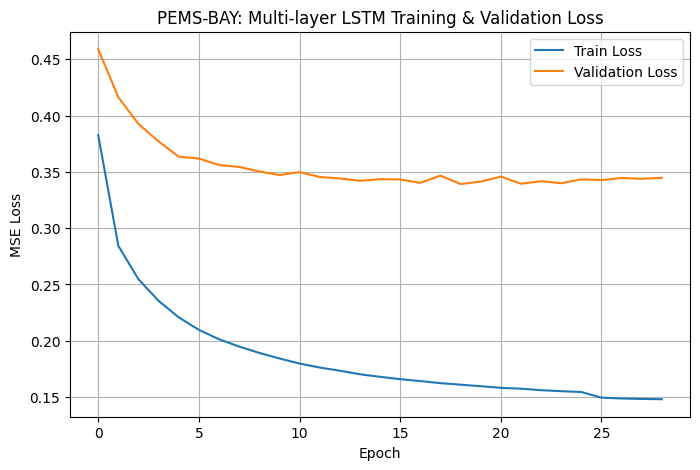

In [ ]:
plotTrainingHistory('PEMS-BAY', train_loss_history, val_loss_history,dir_path)

Test MSE: 20.8092 | MAE: 2.5086 | RMSE: 4.5617 | WAPE: 4.0159


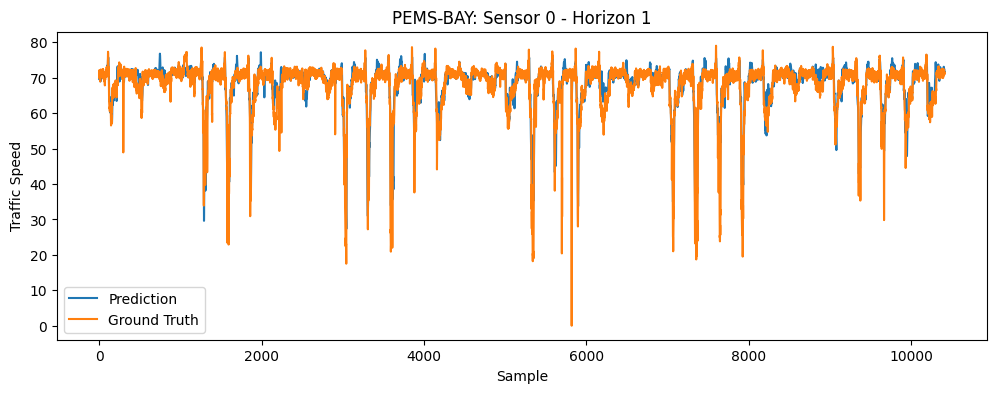

In [ ]:
evaluate('PEMS-BAY', model, scaler, test_loader, dir_path)